# Data Loading and Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_66Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_AllAgree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/README.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/License.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_75Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_50Agree.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv',
                 encoding='unicode_escape',
                 names=['Sentiment', 'Text'])
print(df.shape)
print('\n'*3)
df.head()

(4846, 2)






,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
df.drop_duplicates(subset=['Text'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4838 non-null   object
 1   Text       4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


<Axes: xlabel='Sentiment'>

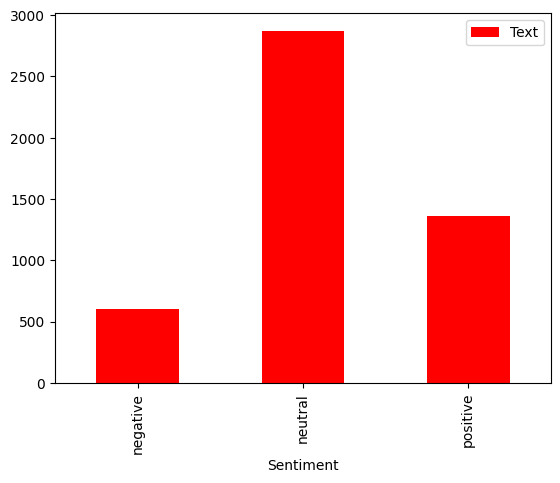

In [5]:
df.groupby('Sentiment').count().plot(kind='bar',color = 'red')

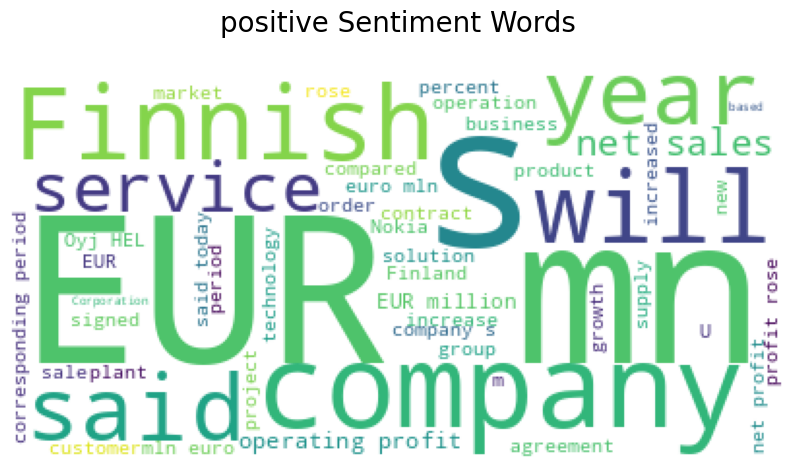

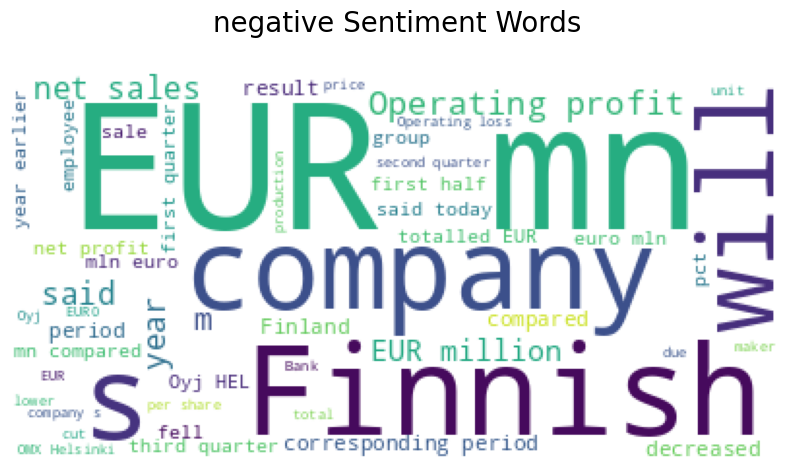

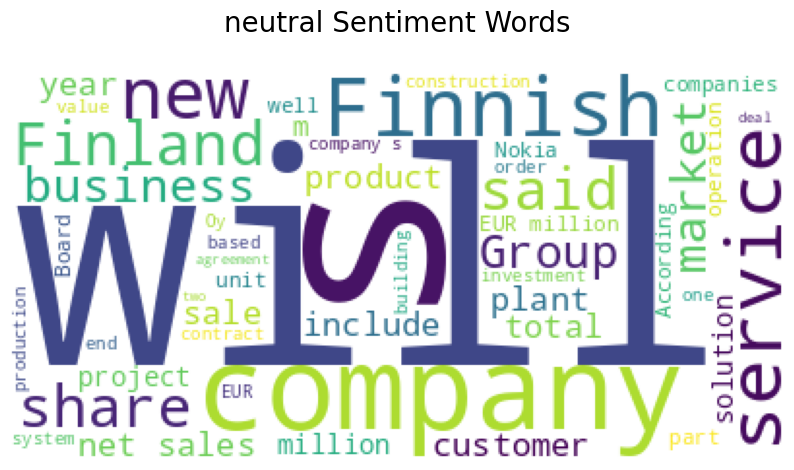

In [6]:
def wordcount_gen(df, category):

    combined_tweets = " ".join([tweet for tweet in df[df.Sentiment == category]['Text']])
                          
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words\n'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
wordcount_gen(df, 'positive')
     
wordcount_gen(df, 'negative')
     
wordcount_gen(df, 'neutral')

In [7]:
example = df['Text'][10]
print(example)

TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Telekom 's offering to its customers .


In [8]:
tokens = nltk.word_tokenize(text = example, language='english')
print(tokens)

['TeliaSonera', 'TLSN', 'said', 'the', 'offer', 'is', 'in', 'line', 'with', 'its', 'strategy', 'to', 'increase', 'its', 'ownership', 'in', 'core', 'business', 'holdings', 'and', 'would', 'strengthen', 'Eesti', 'Telekom', "'s", 'offering', 'to', 'its', 'customers', '.']


# VADER Model

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('I love cookie')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [11]:
sia.polarity_scores('I hate cookie')

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [12]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'compound': 0.5574}

In [13]:
predicted_sentiments = []
for text in df['Text']:
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        predicted_sentiments.append('positive')
    elif score['compound'] <= -0.05:
        predicted_sentiments.append('negative')
    else:
        predicted_sentiments.append('neutral')

df['predicted_sia'] = predicted_sentiments

In [14]:
df

,Sentiment,Text,predicted_sia
0,neutral,"According to Gran , the company has no plans t...",negative
1,neutral,Technopolis plans to develop in stages an area...,negative
2,negative,The international electronic industry company ...,neutral
3,positive,With the new production plant the company woul...,positive
4,positive,According to the company 's updated strategy f...,positive
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive
4844,negative,Net sales of the Paper segment decreased to EU...,positive


# ProsusAI/finbert Model

In [15]:
X = df['Text'].to_list()
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [16]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [17]:
df['predicted_finbert'] = preds

In [18]:
df

,Sentiment,Text,predicted_sia,predicted_finbert
0,neutral,"According to Gran , the company has no plans t...",negative,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral
2,negative,The international electronic industry company ...,neutral,negative
3,positive,With the new production plant the company woul...,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative


# twitter-roberta-base-sentiment Model

In [19]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [20]:
preds_roberta = []
preds_proba_roberta = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_roberta(**input_sequence).logits
        scores = scipy.special.softmax(logits.numpy().squeeze())
        labels = ['negative', 'neutral', 'positive']
        scores_dict = {label: score for label, score in zip(labels, scores)}
        sentimentRoberta = max(scores_dict, key=scores_dict.get)
        probabilityRoberta = max(scores_dict.values())
        preds_roberta.append(sentimentRoberta)
        preds_proba_roberta.append(probabilityRoberta)

In [21]:
df['predicted_roberta'] = preds_roberta; df

,Sentiment,Text,predicted_sia,predicted_finbert,predicted_roberta
0,neutral,"According to Gran , the company has no plans t...",negative,neutral,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral,neutral
2,negative,The international electronic industry company ...,neutral,negative,negative
3,positive,With the new production plant the company woul...,positive,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive,neutral
...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative,neutral
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative,neutral


In [22]:
y = df['Sentiment'].to_list()

In [23]:
print(f'Accuracy-Score: {accuracy_score(y, predicted_sentiments)}')

Accuracy-Score: 0.5431996692848284


In [24]:
df

,Sentiment,Text,predicted_sia,predicted_finbert,predicted_roberta
0,neutral,"According to Gran , the company has no plans t...",negative,neutral,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral,neutral
2,negative,The international electronic industry company ...,neutral,negative,negative
3,positive,With the new production plant the company woul...,positive,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive,neutral
...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative,neutral
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative,neutral
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative,neutral


# yiyanghkust/finbert-tone Model

In [25]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

results = df['Text'].apply(lambda x: nlp(x)[0])

df['predicted_finbertTone'] = results.apply(lambda x: x['label'].lower())


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [26]:
df

,Sentiment,Text,predicted_sia,predicted_finbert,predicted_roberta,predicted_finbertTone
0,neutral,"According to Gran , the company has no plans t...",negative,neutral,neutral,neutral
1,neutral,Technopolis plans to develop in stages an area...,negative,neutral,neutral,neutral
2,negative,The international electronic industry company ...,neutral,negative,negative,neutral
3,positive,With the new production plant the company woul...,positive,positive,positive,positive
4,positive,According to the company 's updated strategy f...,positive,positive,neutral,positive
...,...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,negative,negative,negative,negative
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,negative,neutral,positive
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,positive,negative,neutral,negative
4844,negative,Net sales of the Paper segment decreased to EU...,positive,negative,neutral,negative


# Model Evaluation Metrics

In [27]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

In [28]:
evaluate_model_accuracy('SentimentIntensityAnalyzer', predicted_sentiments)
evaluate_model_accuracy('ProsusAI/finbert', preds)
evaluate_model_accuracy('cardiffnlp/twitter-roberta-base-sentiment', preds_roberta)
evaluate_model_accuracy('yiyanghkust/finbert-tone', df.predicted_finbertTone)

Model: SentimentIntensityAnalyzer - Accuracy-Score: 0.5432
Model: ProsusAI/finbert - Accuracy-Score: 0.8892
Model: cardiffnlp/twitter-roberta-base-sentiment - Accuracy-Score: 0.6664
Model: yiyanghkust/finbert-tone - Accuracy-Score: 0.7925


In [29]:
print(classification_report(y,preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2872
    positive       0.81      0.92      0.86      1362

    accuracy                           0.89      4838
   macro avg       0.86      0.92      0.88      4838
weighted avg       0.90      0.89      0.89      4838



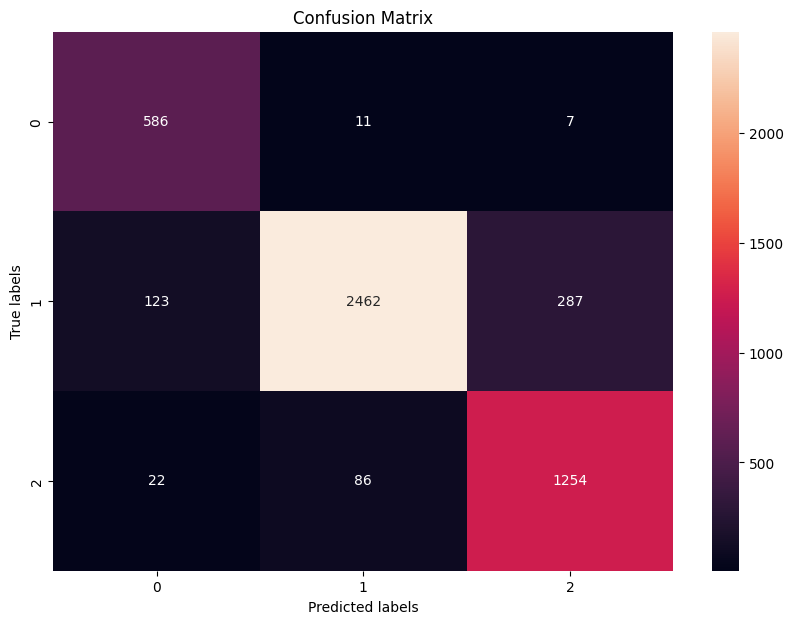

In [30]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()